# DTSA-5511,  Final: Lyrics generator
### October 6, 2023


This jupyter notebok is uploaded to https://github.com/daisukexp/dtsa5511_final

In [39]:
import sys
import platform
import os
import warnings

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import tensorflow as tf

import time

import string
import nltk
#nltk.download('punkt')

import re

import visualkeras

from collections import Counter

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from keras import regularizers

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential, Model
from keras.layers import Embedding, Input, LSTM, GRU, Dense, Dropout, Flatten, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from keras import backend as K

train_on_gpu = True

warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)

In [13]:
sys.version

'3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]'

In [14]:
tf.__version__

'2.10.1'

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
if train_on_gpu:
    !nvidia-smi

Thu Oct  5 23:24:49 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P2              38W / 200W |  11607MiB / 12282MiB |     35%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Step 1 : Gather data, determine the method of data collection and provenance of the data

### Introduction
For the culminating project in my Deep Learning course, it was imperative to select a subject that resonated with personal interests. Given the pervasive influence of music in my life, I turned my attention to areas within this realm. My decision was to leverage a dataset that facilitates the generation of lyrics across distinct musical genres, such as Rock, Pop, Heavy Metal, and Hip Hop.

### About Dataset

The dataset, titled "Song Lyrics from 79 Musical Genres", was sourced from Kaggle. While the primary application of this dataset pertains to the prediction of musical genres based on lyrics, for the scope of this project, it serves as a reservoir of lyrics classified by genre or artist.

The dataset can be accessed at the following link:

https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres/data


There are two main files in this dataset: artists-data.csv and lyrics-data.csv.

# Step 2 : Identify a Deep Learning Problem

### Problem Definition
In the vast landscape of music, each genre carries its distinct linguistic nuances, characterized by specific words and phrases that resonate with its essence. Our primary objective in this study is to develop a system that, when provided with a specified genre, can generate lyrics that seamlessly align with the linguistic intricacies unique to that genre. By harnessing the power of deep learning and drawing insights from our chosen dataset, we aspire to generte lyrics of the designated genre.

### Approach & Methodology
Our methodology distinguishes itself from typical solutions found on platforms like Kaggle, which often focus primarily on visualizing dataset trends. Our approach is more holistic, encompassing the following elements:

- Build Multiple Models:
We plan to develop and test several RNN models. Our aim is to evaluate their performance in generating lyrics. By comparing the results, we can determine the most effective model for our purposes.

- Analysis:
Our analysis is multifaceted. In this project, we emphasize computational efficiency during model construction, in addition to prioritizing model accuracy. This dual focus ensures our model is not only precise but also performance-optimized. By adopting this approach, we aim to provide an effective solution to the challenge at hand.

# Step 3 : Exploratory Data Analysis(EDA) - Inspect, Visualize and Clean the Data


### Initial inspection  and cleaning

In [17]:
df_lyrics = pd.read_csv('data/lyrics-data.csv')

In [18]:
df_lyrics

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt
...,...,...,...,...,...
379926,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en
379927,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en
379928,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en
379929,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en


In [19]:
df_artists = pd.read_csv('data/artists-data.csv')
df_artists

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/
...,...,...,...,...,...
4163,Miriam Makeba,World Music; Black Music; Blues,17.0,0.0,/miriam-makeba/
4164,Freddie Aguilar,World Music,61.0,0.0,/freddie-aguilar/
4165,Amadou & Mariam,World Music,14.0,0.0,/amadou-mariam/
4166,Magic System,World Music; Gospel/Religioso,16.0,0.0,/magic-system/


Drop unused fields and merge the lyrics with artist information. Retain only songs in English.

In [20]:
df_merged = pd.merge(df_lyrics, df_artists, left_on='ALink', right_on='Link')
df_merged = pd.merge(df_lyrics, df_artists, left_on='ALink', right_on='Link', how='outer')
df_merged = df_merged[df_merged['language'] == 'en']
df_merged.drop(columns=['ALink', 'Link', 'SLink', 'Songs', 'Popularity', 'SName', 'language'], inplace=True)
df_merged

,Lyric,Artist,Genres
69,I feel so unsure\nAs I take your hand and lead...,Ivete Sangalo,Pop; Axé; Romântico
86,"Don't let them fool, ya\nOr even try to school...",Ivete Sangalo,Pop; Axé; Romântico
88,"Baby, let's cruise, away from here\nDon't be c...",Ivete Sangalo,Pop; Axé; Romântico
111,"Know it sounds funny\nBut, I just can't stand ...",Ivete Sangalo,Pop; Axé; Romântico
140,You've got that look again\nThe one I hoped I ...,Ivete Sangalo,Pop; Axé; Romântico
...,...,...,...
379926,Chorus\nHere we stand waiting on the plain\nDa...,Johnny Clegg,World Music; Gospel/Religioso
379927,I nearly disappeared into the mouth of a croco...,Johnny Clegg,World Music; Gospel/Religioso
379928,"Amambuka, amambuka azothengisa izwe lakithi, i...",Johnny Clegg,World Music; Gospel/Religioso
379929,Sweat in the heat for days on end\nwaiting for...,Johnny Clegg,World Music; Gospel/Religioso


Drop rows where the "Lyric" or "Genres" columns are missing.

In [21]:
df_merged.isna().sum()

Lyric       0
Artist    427
Genres    436
dtype: int64

In [22]:
df_merged = df_merged.dropna(subset=['Lyric', 'Genres'])

Retain only first one in Genre columns

In [23]:
df_merged['Genres'] = df_merged['Genres'].str.split(';').str[0]

Pick up top 5 genres

In [24]:
genre_counts = df_merged['Genres'].value_counts()
top_5_genres = genre_counts.head(5)
top_5_genres

Genres
Rock           25177
Pop            13759
Heavy Metal    13496
Indie          12998
Rap             9589
Name: count, dtype: int64

Calculate average number of word in lyrics

In [25]:
df_merged['word_count'] = df_merged['Lyric'].str.split().apply(len)
average_word_count = df_merged['word_count'].mean()
average_word_count

250.51645957215564

In [26]:
df_filtered = df_merged
df_filtered

,Lyric,Artist,Genres,word_count
69,I feel so unsure\nAs I take your hand and lead...,Ivete Sangalo,Pop,299
86,"Don't let them fool, ya\nOr even try to school...",Ivete Sangalo,Pop,161
88,"Baby, let's cruise, away from here\nDon't be c...",Ivete Sangalo,Pop,159
111,"Know it sounds funny\nBut, I just can't stand ...",Ivete Sangalo,Pop,175
140,You've got that look again\nThe one I hoped I ...,Ivete Sangalo,Pop,215
...,...,...,...,...
379926,Chorus\nHere we stand waiting on the plain\nDa...,Johnny Clegg,World Music,198
379927,I nearly disappeared into the mouth of a croco...,Johnny Clegg,World Music,137
379928,"Amambuka, amambuka azothengisa izwe lakithi, i...",Johnny Clegg,World Music,221
379929,Sweat in the heat for days on end\nwaiting for...,Johnny Clegg,World Music,260


We have 191378 English songs with Artist and Genres information.

### Visualize

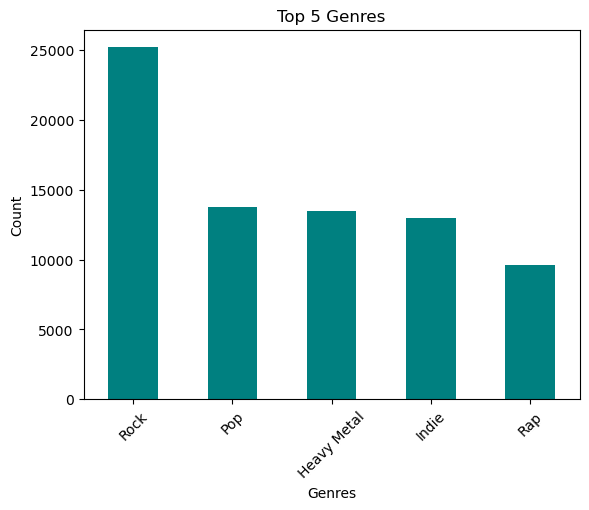

In [27]:
genres_split = df_filtered['Genres']
top_genres = genres_split.value_counts().head(5)

top_genres.plot(kind='bar', color='teal')
plt.title('Top 5 Genres')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

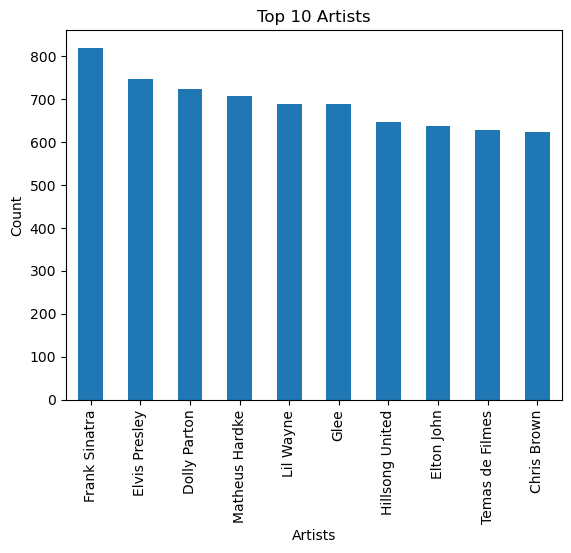

In [28]:
top_artists = df_filtered['Artist'].value_counts().head(10)
top_artists.plot(kind='bar')
plt.title('Top 10 Artists')
plt.xlabel('Artists')
plt.ylabel('Count')
plt.show()

# Step 4 : Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions 

## 4.1 : Model Selection

For generating text based on a specified genre, a recurrent neural network (RNN) is typically a good choice due to its ability to maintain memory of past sequences, which is essential for understanding the structure and continuity in texts. More specifically, the belows are the deep learning models we considered for this project:

### LSTM (Long Short-Term Memory):
This is a type of RNN that can learn and remember over long sequences and is less susceptible to the vanishing gradient problem. Given the complexity and length of lyrics, LSTMs are a solid choice for this task.

### GRU (Gated Recurrent Units):
GRUs are similar to LSTMs but with a simpler structure. They can sometimes perform equally well but can be faster to train due to the reduced complexity.

### Transformer Models:
While originally designed for translation tasks, transformer models like BERT, GPT-2, and GPT-3 have shown incredible results in text generation. They can capture longer-range dependencies in the text compared to RNNs. If we have the computational resources and are looking for state-of-the-art results, we might consider fine-tuning a pre-trained transformer model on the dataset.

### Seq2Seq Models:
While more commonly used for tasks like translation, they can also be adapted for text generation. A Seq2Seq model can take a genre as input and produce a sequence of lyrics as output.


### Employed model
For our project, after evaluating the various deep learning models available, we settled on two specific architectures, namely LSTM and GRU. The reasons for our choices are outlined below:

- LSTM : Memory Retention, Mitigation of Vanishing Gradient and Versatility
- GRU : Simpler Architecture, Peformance and Efficiency

## 4.2 LSTM

### Preprocessing

### Prepare traing dataset for the target domain
In this Jupytor Notebook, we show our work for Pop music. Other experiments to be covered by a presentaion.

In [29]:
#df_test = df_filtered[df_filtered['Genres'] == 'Indie'].sample(n=100, replace=False, random_state=123)
#df_test = df_filtered[df_filtered['Artist'] == 'David Bowie'].sample(n=100, replace=False, random_state=123)
df_test = df_filtered[df_filtered['Genres'] == 'Pop'].sample(n=100, replace=False, random_state=123)

df_test.head(10)

,Lyric,Artist,Genres,word_count
262103,"Baby, if I tell you what I want\nDon't call me...",JoJo,Pop,530
259567,Now listen I think you and me\nHave come to th...,Lily Allen,Pop,426
33784,Girl you're beautiful\nYou're 'bout near perfe...,Lady A,Pop,266
265440,The air attack warning sounds like\nThis is th...,Frankie Goes To Hollywood,Pop,195
57137,"(Shanell Verse)\nBaby, Can I come over and pla...",Shanell,Pop,317
975,This is my carnaval aye aye aye ha\n(Mr. World...,Claudia Leitte,Pop,532
55419,Notice me\nTake my hand\nWhy are we\nStrangers...,Cher Lloyd,Pop,120
251443,I miss the taste of a sweeter life\nI miss the...,Maroon 5,Pop,448
265551,"Christmas, Christmas time is near\nTime for to...",Alvin & The Chipmunks,Pop,82
265752,Sometimes I feel I wanna fly away\nWith you my...,Sugababes,Pop,145


### Tokenization

The tokenization is crucial part for preparing text data for nueral network training.The primary tasks include tokenization, sequence generation, and data splitting into predictors and labels.

#### Tokenization:
Tokenization is the process of converting text into numerical tokens. These tokens typically represent words or characters. It's a fundamental step in many natural language processing (NLP) tasks since machines understand numbers better than raw text.
The Tokenizer from Keras is instantiated, which will help in the tokenization process.
fit_on_texts method is then called on the 'Lyric' column of the df_test dataframe to tokenize the lyrics. The lyrics are converted to lowercase before tokenization to ensure uniformity.
The total number of unique words is stored in total_words, which will be useful later when defining the neural network architecture.
The texts_to_sequences method is then used to convert the lyrics into a sequence of tokens.


#### Generating n-gram sequences:

This section of the code takes the tokenized sentences and breaks them down into n-gram sequences. N-gram sequences are contiguous sequences of 'n' items from the original sentence. This is done to create a dataset where given a sequence of words, the next word can be predicted.
For instance, from the sentence "I study machine learning", the n-gram sequences generated would include "I study", "I study machine", and "I study machine learning".


#### Padding:

Neural networks require input data to have a consistent shape. But our n-gram sequences will have variable lengths. To handle this, padding is used.
The pad_sequences function from Keras adds zeros to ensure that all sequences have the same length, which is the length of the longest sequence.
In this code, padding is added to the beginning of sequences, as specified by padding='pre'.


#### Splitting data into predictors and labels:

The goal of the model will be to predict the next word in a sequence. So, the last word of each sequence is used as a label, and the rest of the sequence is used as the input data.
The X variable contains the input sequences without the last word, while the labels variable contains only the last word from each sequence.
The to_categorical function is used to convert the labels into a one-hot encoded format, which is a binary matrix representation of the labels. This is done because it's a multi-class classification problem where each word in our vocabulary is a separate class.

In [30]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_test['Lyric'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(df_test['Lyric'].astype(str))

In [31]:
# Slash sequences into n gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
# Pre padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [32]:
# create predictors and label
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

### Model training

#### Long Short-Term Memory (LSTM):
LSTM stands for Long Short-Term Memory. It is a type of recurrent neural network (RNN) architecture. RNNs are neural networks designed to recognize patterns over sequences of data, such as time series or text. However, basic RNNs suffer from vanishing and exploding gradient problems, which makes them less efficient at capturing long-term dependencies in a sequence. LSTM was designed to overcome these challenges. They are equipped with gates (input, forget, and output gates) that regulate the flow of information, allowing them to capture both short-term and long-term dependencies in sequence data.

- An Embedding layer is added first, which converts tokenized words into dense vectors of fixed size, in this case, 40 dimensions.
- A Bidirectional LSTM layer with 250 units follows the Embedding layer. The bidirectional wrapper around the LSTM means that the LSTM will consider the sequence in both its original order and its reverse, potentially capturing patterns that may be overlooked when considering the sequence in just one direction. The number 250 in LSTM(250) refers to the number of LSTM units or neurons, which was chosen based on the average number of words in songs.
- A Dropout layer is added with a dropout rate of 0.1 to prevent overfitting. This layer randomly sets a fraction of input units to 0 at each update during training, which helps prevent overfitting.
- Finally, a Dense layer with a softmax activation function is added. This layer will predict the probability distribution of the next word over the entire vocabulary.

In [33]:
# create model
model_lstm = Sequential()
model_lstm.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
model_lstm.add(Bidirectional(LSTM(250)))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(total_words, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 925, 40)           101960    
                                                                 
 bidirectional (Bidirectiona  (None, 500)              582000    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 2549)              1277049   
                                                                 
Total params: 1,961,009
Trainable params: 1,961,009
Non-trainable params: 0
_________________________________________________________________


Let's train the LSTM model. We've set the number of epochs to 40 based on numerous trials and testing. The training will be halted by the earlystop callback if it monitors no improvement in the training loss.

In [39]:
start_time = time.time()

history_lstm = model_lstm.fit(X, y, epochs=40, verbose=1, callbacks=[earlystop], batch_size=128)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {round(elapsed_time, 1)} seconds")

Epoch 1/40
230/230 [==============================] - 23s 101ms/step - loss: 3.6956 - accuracy: 0.2744
Epoch 2/40
230/230 [==============================] - 23s 100ms/step - loss: 3.4094 - accuracy: 0.3133
Epoch 3/40
230/230 [==============================] - 23s 100ms/step - loss: 3.1648 - accuracy: 0.3500
Epoch 4/40
230/230 [==============================] - 23s 101ms/step - loss: 2.9642 - accuracy: 0.3828
Epoch 5/40
230/230 [==============================] - 23s 101ms/step - loss: 2.8151 - accuracy: 0.4073
Epoch 6/40
230/230 [==============================] - 23s 99ms/step - loss: 2.6816 - accuracy: 0.4337
Epoch 7/40
230/230 [==============================] - 23s 99ms/step - loss: 2.5680 - accuracy: 0.4526
Epoch 8/40
230/230 [==============================] - 23s 99ms/step - loss: 2.4599 - accuracy: 0.4731
Epoch 9/40
230/230 [==============================] - 23s 100ms/step - loss: 2.3697 - accuracy: 0.4914
Epoch 10/40
230/230 [==============================] - 24s 106ms/step - loss

In [ ]:
#K.clear_session()

## 4.3 GRU

### Model training

#### Gated Recurrent Unit (GRU):
GRU is a type of recurrent neural network (RNN) architecture designed to deal with the vanishing gradient problem that traditional RNNs face. It achieves this with a simplified gating mechanism compared to the LSTM (Long Short-Term Memory) network, another popular RNN variant. The gates in a GRU help the model decide how much of the new input should be considered and how much of the previous memory should be retained. Due to its simplified structure, GRUs are often faster to train than LSTMs, while still retaining a considerable ability to capture temporal dependencies.

- An Embedding layer is added first. This layer maps each token (word) to a 40-dimensional vector, capturing the semantic meaning of the words.
- A Bidirectional GRU layer with 250 units is added.
- A Dropout layer is introduced with a rate of 0.1 to prevent overfitting. Dropout randomly sets a fraction of the input units to 0 at each training step, which helps in regularizing the model.
- A Dense layer with a softmax activation function predicts the probability distribution over the entire vocabulary for the next word in the sequence.
- The model is compiled with the categorical crossentropy loss function (suitable for multi-class classification) and the Adam optimizer.

In [40]:
# Create predictors and label
X, labels = input_sequences[:, :-1], input_sequences[:, -1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Create the model with GRU
model_gru = Sequential()
model_gru.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
model_gru.add(Bidirectional(GRU(250)))  # Using GRU here
model_gru.add(Dropout(0.1))
model_gru.add(Dense(total_words, activation='softmax'))
model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 925, 40)           101960    
                                                                 
 bidirectional_1 (Bidirectio  (None, 500)              438000    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 2549)              1277049   
                                                                 
Total params: 1,817,009
Trainable params: 1,817,009
Non-trainable params: 0
_________________________________________________________________


In [40]:
start_time = time.time()

history_gru = model_gru.fit(X, y, epochs=40, verbose=1, callbacks=[earlystop], batch_size=128)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {round(elapsed_time, 1)} seconds")

Epoch 1/40
230/230 [==============================] - 23s 98ms/step - loss: 0.4483 - accuracy: 0.8982
Epoch 2/40
230/230 [==============================] - 24s 102ms/step - loss: 0.3395 - accuracy: 0.9272
Epoch 3/40
230/230 [==============================] - 22s 98ms/step - loss: 0.2902 - accuracy: 0.9387
Epoch 4/40
230/230 [==============================] - 22s 97ms/step - loss: 0.2538 - accuracy: 0.9486
Epoch 5/40
230/230 [==============================] - 22s 97ms/step - loss: 0.2361 - accuracy: 0.9525
Epoch 6/40
230/230 [==============================] - 22s 97ms/step - loss: 0.2155 - accuracy: 0.9570
Epoch 7/40
230/230 [==============================] - 22s 98ms/step - loss: 0.1918 - accuracy: 0.9630
Epoch 8/40
230/230 [==============================] - 22s 97ms/step - loss: 0.1835 - accuracy: 0.9631
Epoch 9/40
230/230 [==============================] - 23s 98ms/step - loss: 0.1763 - accuracy: 0.9646
Epoch 10/40
230/230 [==============================] - 22s 98ms/step - loss: 0.16

## 4.3 Analysis



### 4.3.1 LSTM

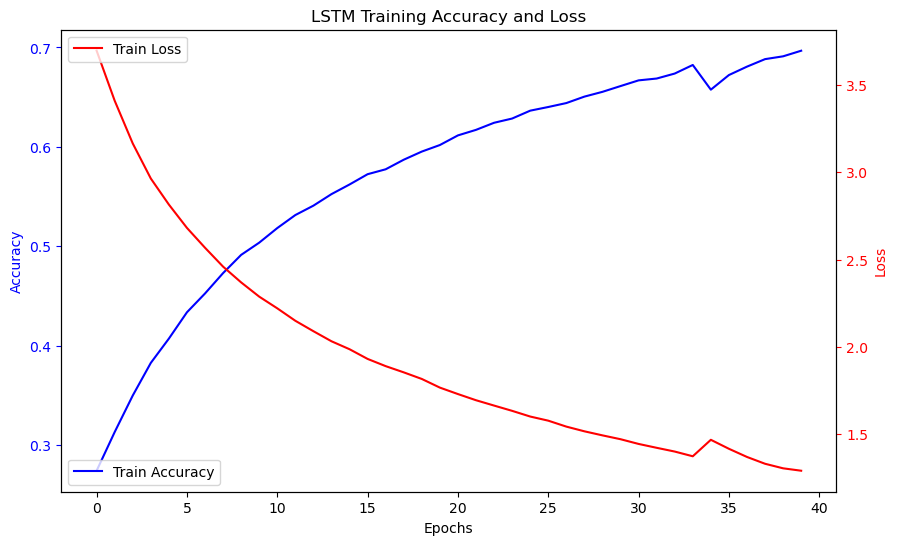

In [58]:
# Create the main figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy on the main axis (ax1)
ax1.plot(history_lstm.history['accuracy'], label='Train Accuracy', color='blue')
ax1.set_title('LSTM Training Accuracy and Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params('y', colors='blue')
ax1.legend(loc='lower left')

# Create a secondary y-axis for the loss
ax2 = ax1.twinx()
ax2.plot(history_lstm.history['loss'], label='Train Loss', color='red')
ax2.set_ylabel('Loss', color='red')
ax2.tick_params('y', colors='red')
ax2.legend(loc='upper left')

plt.show()

The below is our observation of training history for LSTM.
- Starting Accuracy: The LSTM model started with an accuracy of approximately 0.2744. This is quite low, indicating the model had a lot of learning to do.
- Final Accuracy: By the end of 40 epochs, the LSTM model achieved an accuracy of approximately 0.6967.
- Trend: The accuracy of the LSTM model gradually increased over the epochs. However, there were some fluctuations, especially after 30 epochs. For instance, there was a noticeable dip in accuracy at epoch 35.
- Overall: The LSTM model showed a steady improvement over the 40 epochs, nearly tripling its accuracy. However, it seems like the model might still have some potential for further improvement or tuning.
- Time to training: 913.1 sec

#### Lyrics generation

In [42]:
def song_generator(seed_text, next_words, model, tokenizer, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted_probs, axis=-1)  # get the class index
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [31]:
song_generator("Why you", 20, model_lstm, tokenizer, max_sequence_len)

"Why you and i don't have to be a little bit of me on me on a time i can make it"

In [32]:
song_generator("I know", 20, model_lstm, tokenizer, max_sequence_len)

"I know and you see me i see you know that you see your love is your heart and you're not you're"

In [33]:
song_generator("Because", 20, model_lstm, tokenizer, max_sequence_len)

"Because i don't know i don't have to be a way you see it on the clock i don't have to"

In [43]:
song_generator("Sushi", 20, model_lstm, tokenizer, max_sequence_len)

"Sushi i know i know that you know that you're leaving not don't know that you know that you're leaving you"

The output from the song generator is not perfect, but it resembles the lyrics of pop music!

Since the model doesn't truly "think", it finds the best matching word based on the context from the training data. Thus, unfamiliar words, such as "Sushi", can confuse the model.

### 4.3.2 GRU

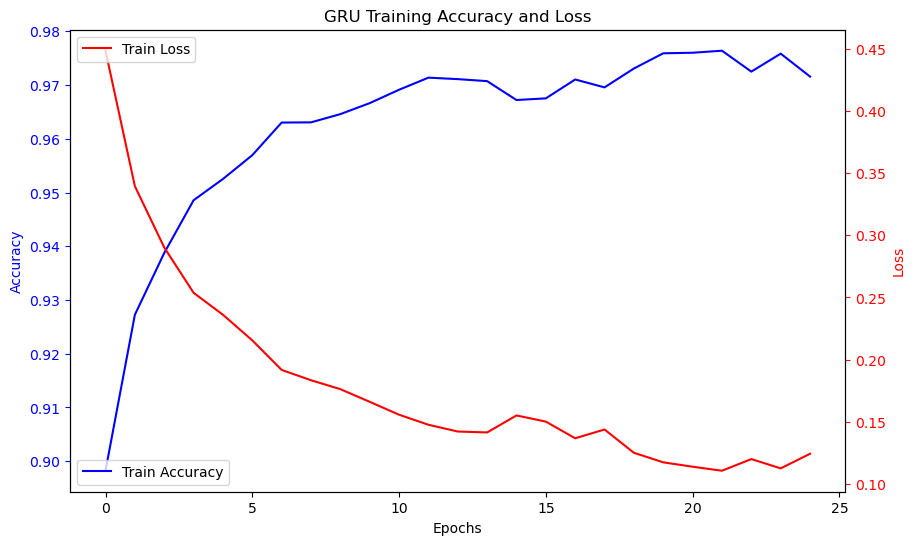

In [59]:
# Create the main figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy on the main axis (ax1)
ax1.plot(history_gru.history['accuracy'], label='Train Accuracy', color='blue')
ax1.set_title('GRU Training Accuracy and Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params('y', colors='blue')
ax1.legend(loc='lower left')

# Create a secondary y-axis for the loss
ax2 = ax1.twinx()
ax2.plot(history_gru.history['loss'], label='Train Loss', color='red')
ax2.set_ylabel('Loss', color='red')
ax2.tick_params('y', colors='red')
ax2.legend(loc='upper left')

plt.show()

The below is our obsrvation of training history for GRU.
- Starting Accuracy: The GRU model began with a significantly high accuracy of approximately 0.8982.
- Final Accuracy: The training of the GRU model was stopped early at the 25th epoch (out of 40) due to the early stopping callback, with a final accuracy of about 0.9716.
- Trend: The accuracy of the GRU model showed rapid improvement in the initial epochs and then began to stabilize. The model maintained a high accuracy throughout, although there were minor fluctuations in the later epochs.
- Overall: The GRU model demonstrated superior performance compared to the LSTM in this specific task, achieving a very high accuracy in fewer epochs. The early stopping suggests that the model might have begun to overfit or wasn't seeing significant improvements, hence the decision to halt training.
- Time to training: 563.8 sec

In [45]:
song_generator("Why you", 20, model_gru, tokenizer, max_sequence_len)

"Why you had to call me now that i can't wanted your plane gets all the words that he first met you"

In [46]:
song_generator("I know", 20, model_gru, tokenizer, max_sequence_len)

"I know you're leavin' babe goodbye so long i hope someday somebody listens to your song those bright lights never ever spell"

In [38]:
song_generator("Because", 20, model_gru, tokenizer, max_sequence_len)

"Because that he don't have a little girl that we didn't care and the world decided to check cause i can"

In [48]:
song_generator("Sushi", 20, model_gru, tokenizer, max_sequence_len)

'Sushi my heart have strong like this too my times i love it so baby when i fall when you see'

The song generator, based on the GRU model, produced a more natural output.

### 4.3.3 Model comparison


In this project, we constructed generative machine learning models. Due to the nature of these models, there isn't a direct metric that can evaluate the generated outputs. However, we can still make comparative assessments between the two models based on the following criteria:

#### Measurable metrics

Training Time & Accuracy: These are quantifiable aspects of the models. Though the time taken for one epoch did not display a notable difference between the two models, the GRU outperformed the LSTM in terms of accuracy. Specifically, the GRU achieved higher accuracy in a shorter amount of time. Based on these findings, we deduced that the GRU model is more suitable for this specific task.


#### Unmeasurebale metrics

Qualitative Comparison of Outputs: We compared the results generated by both the LSTM and GRU models, keeping in mind that they were trained on the same dataset. When evaluated subjectively by human observation, the output from the GRU model appeared more natural and emotionally resonant. This heightened quality of the GRU's output could likely be attributed to its accuracy in training.

### 4.4 Conclusion

We successfully met the objectives of this project, training a generative machine learning model capable of crafting lyrics aligned with a designated music genre. Though the training codebase may seem succinct, it masks the significant effort expended on research, experimentation, and iterative testing that formed the backbone of this project.

In future endeavors, we intend to delve deeper into factors related to emotion, aiming to yield more natural and captivating outputs. For instance, we're considering the integration of human emotional responses, such as popularity scores and review ratings, to further refine the generated lyrics.

This project was a profound learning journey. We were genuinely enthralled by the complexities of generative AI and found immense satisfaction in actively participating in the model-building process.

Concluding our machine learning specialization with this course, we've amassed several indispensable skills crucial for any aspiring data scientist:

- Mastery over foundational concepts of machine learning.
- A robust understanding of pivotal subjects and tools.
- Practical experience, underscored by hands-on projects, fostering essential problem-solving abilities.

It's worth noting that the journey of a data scientist is one of perpetual learning. Embracing a mindset of continuous growth and adaptability is paramount in this ever-evolving field. Thank you!

# Reference
- https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres/data
- https://towardsdatascience.com/lstm-by-example-using-tensorflow-feb0c1968537
- https://regenerativetoday.com/implementation-of-simplernn-gru-and-lstm-models-in-keras-and-tensorflow-for-an-nlp-project/